In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

<img src=https://i.stack.imgur.com/gyuw4.png>

In [20]:
def get_color_pixels(image, color):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    if color == "black":
        return cv2.inRange(image_hsv, (0, 0, 0), (180, 255, 30))

    elif color == "green":
        return cv2.inRange(image_hsv, (40, 50, 30), (75, 255, 255))
        
    elif color == "red":
        mask1 = cv2.inRange(image_hsv, (0, 70, 50), (10, 255, 255))
        mask2 = cv2.inRange(image_hsv, (170, 70, 50), (180, 255, 255))
        return cv2.bitwise_or(mask1, mask2)
    
    else:
        raise ValueError(f"Color parameter must be one of 'black', 'green', 'red'. Got: {color}")

Before doing anything, we will load an image that will help us see if the function does what we want

In [26]:
from scripts import *

# use loader to get labels and images
d = DataLoader()

(4608, 3456, 3)
{'P1': 'QD', 'P2': '3S', 'P3': '1D', 'P4': '0D', 'D': 2}


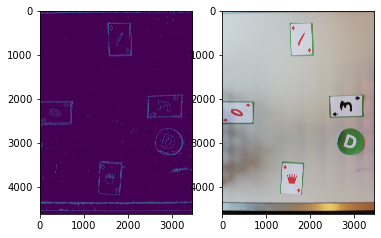

In [27]:
# get one game one round
img_test, label = d[6, 8]
gradient_img = cv2.Canny(img_test,25,100)

##
fig,ax = plt.subplots(1,2)
ax[0].imshow(gradient_img)
print(img_test.shape)
print(label)

ax[1].imshow(img_test[:,:,::-1])

##########################################

Script to get the croped out values, just need to move this around, cz I didn't know where to put this.

In [28]:
n_rounds = 13

target_path = './media/cropped_images/'
game = 7
try:
    os.makedirs(target_path + 'game' + str(game))
except:
    print('file already exists')

file already exists


In [191]:
for n_round in range(1, n_rounds+1):
    img, _ = d[game, n_round]
    print('image {}'.format(n_round))

    c, r1, r2, r3, r4 = extract(img)
    
    cv2.imwrite(target_path+str(game)+'/'+str(n_round)+'c.jpg', cv2.cvtColor(c, cv2.COLOR_RGB2BGR))
    cv2.imwrite(target_path+str(game)+'/'+str(n_round)+'r1.jpg',cv2.cvtColor(r1, cv2.COLOR_RGB2BGR))
    cv2.imwrite(target_path+str(game)+'/'+str(n_round)+'r2.jpg',cv2.cvtColor(r2, cv2.COLOR_RGB2BGR))
    cv2.imwrite(target_path+str(game)+'/'+str(n_round)+'r3.jpg',cv2.cvtColor(r3, cv2.COLOR_RGB2BGR))
    cv2.imwrite(target_path+str(game)+'/'+str(n_round)+'r4.jpg',cv2.cvtColor(r4, cv2.COLOR_RGB2BGR))

image 1
Contour Expressing...
Extracting Circle Dealer...


KeyboardInterrupt: 

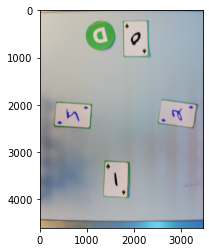

In [11]:
images, label = d[4,8]
plt.imshow(images)

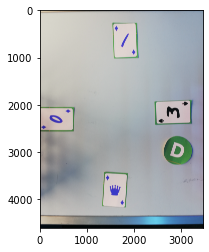

In [12]:
images, label = d[6,8]
plt.imshow(images)

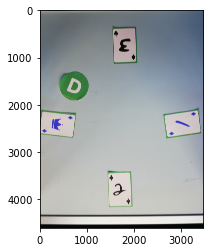

In [13]:
images, label = d[7,5]
plt.imshow(images)

##########################################

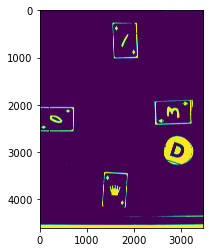

In [32]:
output_red   = get_color_pixels(img_test, "red")
output_green = get_color_pixels(img_test, "green")
output_black = get_color_pixels(img_test, "black")
output = output_red + output_green + output_black
plt.imshow(output)

### Isolate elements
Now that we have isolated everything, we can start to draw boxes around each motif

<b> Bbox for circle </b>

We in reality simply need the center of the circle and its radius for its purpose of knowing who the dealer is, but let's isolate it anyways. (not need to mask it out)

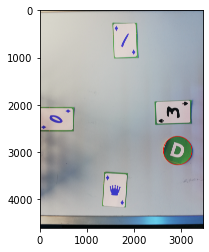

In [33]:
circled = img_test.copy()

min_votes = 5000

# output -> contour made very obvious by color extract
circles = cv2.HoughCircles(output_green,cv2.HOUGH_GRADIENT,1,min_votes,
                            param1=50,param2=30)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(circled,(i[0],i[1]),i[2],(255,0,0),10)
    # draw the center of the circle
#    cv2.circle(circled,(i[0],i[1]),2,(0,0,255),3)

plt.imshow(circled)

In [34]:
x,y,r = circles[0][0]
print('Center of circle found ({},{}) and its radius {}'.format(x,y,r))

Center of circle found (2900,2972) and its radius 301


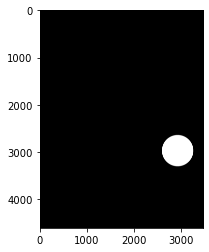

In [35]:
blank = np.zeros_like(img_test)
cv2.circle(blank, (x,y), int(r*1.1), (255,255,255), -1)
plt.imshow(blank)

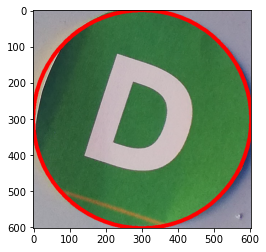

In [36]:
plt.imshow(circled[y-r:y+r,x-r:x+r])

<b> Bbox for the cards </b>

Getting a mask as well since we need to extract the rectangle itself. 
In truth we can get the bounding box over only the cards and not the symbol, so keeping the green extract is enough.

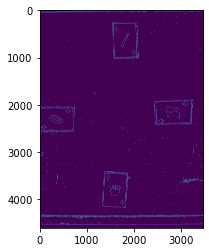

In [37]:
rect_test = gradient_img.copy()
# mask the circle to focus on the rectangles
# enlarge by a little the circle to mask it properly 
rect_test = cv2.circle(rect_test, (x,y), int(r*1.1), (0,0,0), -1)
plt.imshow(rect_test)

In [201]:
from scipy.ndimage import gaussian_filter

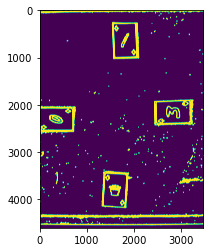

In [202]:
# I didn't really get why you are adding this line, the output
# it seems that it gives out the same image as `output`
# ret, thresh = cv2.threshold(output, 127, 255, 0) 

blank = np.zeros_like(rect_test)

contours,hierarchy = cv2.findContours(gaussian_filter(rect_test,sigma=5), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#cv2.drawContours(img, contours, -1, color=(255, 255, 255), thickness=cv2.FILLED)
cv2.drawContours(blank, contours, -1, (255,255,255), thickness=cv2.FILLED)
plt.imshow(blank)

The following code came from : https://stackoverflow.com/questions/59658830/how-can-we-add-bounding-box-around-canny-edge-detection-output


In [181]:
array_contour = [contour.reshape(np.array(contour.shape)[[0,2]]) for contour in contours]

In [182]:
# take top four contours (top in terms of size of array)
top_four = np.asarray([(i,array_contour[i].shape[0]) for i in range(len(array_contour))])
# might need to change from top_four criteria, to good enough number of points 
top_four = np.array(sorted(top_four,key=lambda x:x[1],reverse=True))
top_four = top_four[:len(top_four)//4,0] #we take half of the largest

In [183]:
# got top four contours  
four_contour = np.array(array_contour)[list(top_four)]

<ipython-input-183-300402d007d5>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  four_contour = np.array(array_contour)[list(top_four)]


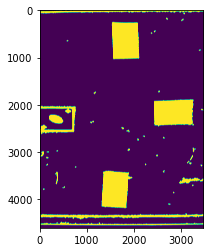

In [184]:
blank = np.zeros_like(rect_test)
# sequential filling, since it's possible that two contours express the same rectangle and therefore
# for some reason it does not fill inside
for one_contour in four_contour:
    cv2.drawContours(blank, [one_contour], -1, (255,255,255), thickness=cv2.FILLED)
plt.imshow(blank)

The code given below is inspired from the one proposed here : https://towardsdatascience.com/image-processing-with-python-color-isolation-for-beginners-3b472293335b


https://stackoverflow.com/questions/57777368/contour-object-detection-and-extraction-in-opencv-python

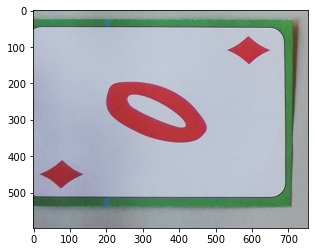

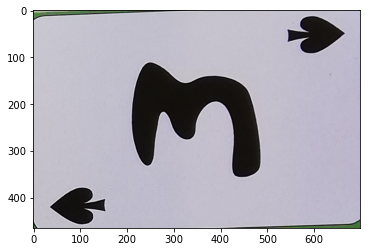

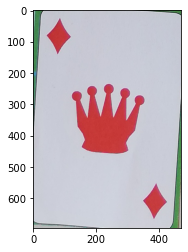

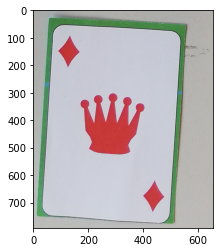

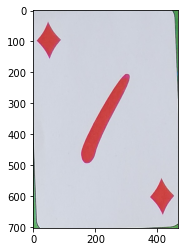

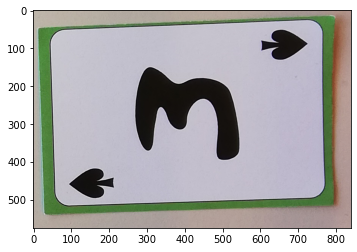

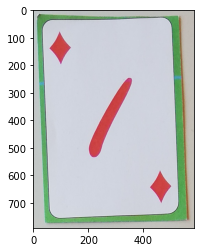

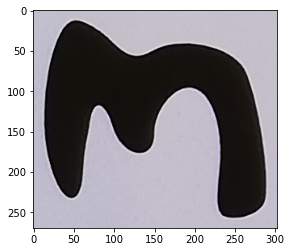

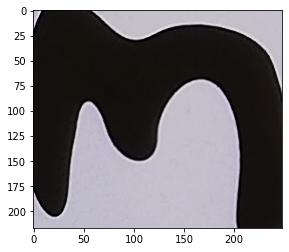

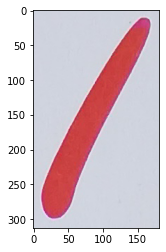

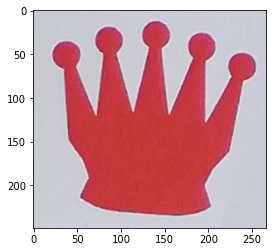

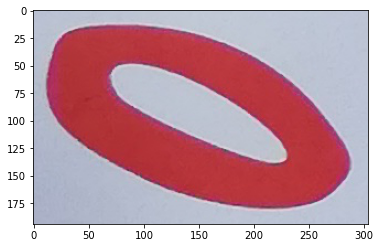

In [185]:
boundRect = [None]*len(four_contour)
for i, c in enumerate(four_contour):
    contours_poly = cv2.approxPolyDP(c, 3, True)###Find contours that are very simiar to rectangle and approximate them as rectangle
    boundRect[i] = cv2.boundingRect(contours_poly)##Plot a rectangle at those boundary

for i in range(len(four_contour)):
    cv2.rectangle(blank, (int(boundRect[i][0]), int(boundRect[i][1])), (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), (0,0,0), 2)

#plt.imshow(img_test)

img_number = 0
plot_w = []
plot_h =[]
index_contours = []
cards = []
for c in four_contour:
    x,y,w,h = cv2.boundingRect(c)
    plot_w.append(w)
    plot_h.append(h)
    index_contours.append(img_number)
    #cv2.rectangle(img_test,(x,y),(x+w,y+h),(36,255,12),3)
    #ROI = img_test[y:y+h, x:x+w]
    #if (430<w<=550 and 600<h<=800) or (430<h<=550 and 600<w<=800) or (200<w<=250 and 150<h<=350) or (200<h<=250 and 200<w<=350) or (430<h<=750 and 600<w<=900):
    if (200<w<=1000 and 150<h<=800) or (200<h<=1000 and 150<w<=800):
        ROI = img_test[y:y+h, x:x+w]
        cards.append(ROI)
    #plt.imshow(ROI)
    #title_ROI = "ROI_{}".format(img_number)
    #plt.title(title_ROI)
    #plt.show()
    img_number +=1

#plt.plot(index_contours,plot_w)
#plt.plot(index_contours,plot_h)
#plt.legend(["w","h"])
#plt.show()
for i in range(0,len(cards)):
    plt.imshow(cards[i])
    plt.show()



In [165]:
num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(blank, 4)
# print(set(labels_im.flatten()))
# plt.imshow(labels_im)

In [59]:
_, r1, r2, r3, r4 = np.array(sorted([(idx,val) for idx,val 
                 in enumerate(stats[:,-1])],
                key=lambda x:x[1],reverse=True))[:,0][:5]

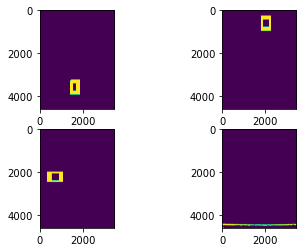

In [60]:
# obviously we are taking the top four largest connected components (except background)
# we can implement that later on

card1 = (labels_im == r1)
card2 = (labels_im == r2)
card3 = (labels_im == r3)
card4 = (labels_im == r4)

fig,ax = plt.subplots(2,2)
ax[0,0].imshow(card1)
ax[0,1].imshow(card2)
ax[1,0].imshow(card3)
ax[1,1].imshow(card4)

In [61]:
def get_rectanglecoords(img):
    # binary_img simply get (from connected components image but masked by label)
    activ_coord = np.where(img)
    ymin,ymax = np.min(activ_coord[0]), np.max(activ_coord[0])
    xmin,xmax = np.min(activ_coord[1]), np.max(activ_coord[1])
    
    return xmin,xmax,ymin,ymax

In [62]:
xmin1, xmax1, ymin1, ymax1 = get_rectanglecoords(card1)
xmin2, xmax2, ymin2, ymax2 = get_rectanglecoords(card2)
xmin3, xmax3, ymin3, ymax3 = get_rectanglecoords(card3)
xmin4, xmax4, ymin4, ymax4 = get_rectanglecoords(card4)

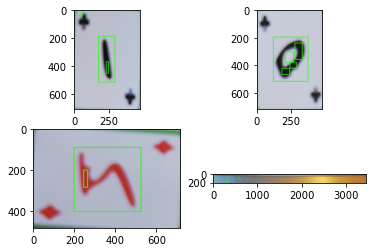

In [63]:
fig,ax = plt.subplots(2,2)
ax[0,0].imshow(img_test[ymin1:ymax1,xmin1:xmax1])
ax[0,1].imshow(img_test[ymin2:ymax2,xmin2:xmax2])
ax[1,0].imshow(img_test[ymin3:ymax3,xmin3:xmax3])
ax[1,1].imshow(img_test[ymin4:ymax4,xmin4:xmax4])